In [1]:
import sys
import os
from pathlib import Path

sys.path.append(os.path.abspath(".."))

import torch
import numpy as np
import umap
import matplotlib.pyplot as plt


from utils.data import (
    download_celeba_data,
    get_celeba_image_np_arrays,
    UMAPImageDataset,
)
from utils.autoencoder import CelebAAutoencoder, MNISTAutoencoder
from utils.loss import UMAPAutoencoderLoss
from utils.train_functions import (
    train_autoencoder,
    train_autoencoder_with_umap,
    test_autoencoder_reconstruction,
    test_autoencoder_umap_embedding,
)

# Load CelebA images

In [2]:
download_celeba_data()

Data is already downloaded. Skipping download.


In [3]:
# WARNING!! The dataset is very large (1.7GB), so this will take a very long time
# Processing 10% of images took me 1 hour to load and compute UMAP embeddings (@ umap embedding_dim=2).
# Best model was trained on the University's DGX cluster.
train_images, test_images = get_celeba_image_np_arrays(process_size=0.01)
full_images = np.concatenate([train_images, test_images], axis=0)

Loading images...
2025 images loaded         


# UMAP embeddings

## Create & Save embeddings

In [4]:
# COMMENTED OUT TO AVOID REGENERATING UMAP EMBEDDINGS
# Remove comments to regenerate UMAP embeddings

embedding_dim = 64

flat_full_images = full_images.reshape(full_images.shape[0], -1)
reducer = umap.UMAP(n_components=embedding_dim)
full_embeddings = reducer.fit_transform(flat_full_images)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

# Save full embeddings to a file
project_dir = Path("..").resolve()
embeddings_file = (
    project_dir
    / "data"
    / "img_align_celeba"
    / "umap_embeddings"
    / f"embeddings_d{embedding_dim}_n{len(full_images)}.npy"
)
embeddings_file.parent.mkdir(parents=True, exist_ok=True)
np.save(embeddings_file, full_embeddings)


## Load embeddings if previously computed

In [ ]:
embedding_dim = 1024

project_dir = Path("..").resolve()
data_dir = project_dir / "data" / "img_align_celeba" / "umap_embeddings"
embeddings_file = data_dir / f"embeddings_d{embedding_dim}_n{len(full_images)}.npy"

full_embeddings = np.load(embeddings_file)
full_images = np.concatenate([train_images, test_images], axis=0)
flat_full_images = full_images.reshape(full_images.shape[0], -1)


# Train Autoencoders

## Train & test split

In [5]:
# Datasets
flat_train_images = train_images.reshape(train_images.shape[0], -1)
flat_test_images = test_images.reshape(test_images.shape[0], -1)

train_embeddings = full_embeddings[: len(train_images)]
test_embeddings = full_embeddings[len(train_images) :]

flat_train_dataset = UMAPImageDataset(
    images=flat_train_images, umap_embeddings=train_embeddings
)
flat_test_dataset = UMAPImageDataset(
    images=flat_test_images, umap_embeddings=test_embeddings
)

flat_train_loader = torch.utils.data.DataLoader(
    flat_train_dataset, batch_size=128, shuffle=False
)
flat_test_loader = torch.utils.data.DataLoader(
    flat_test_dataset, batch_size=128, shuffle=False
)


## Train normal Autoencoder

In [7]:
autoencoder_input_dim = flat_full_images.shape[1]
normal_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)
normal_criterion = torch.nn.MSELoss()
normal_optimizer = torch.optim.Adam(normal_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

normal_num_epochs = 10

train_autoencoder(
    model=normal_autoencoder,
    dataloader=flat_train_loader,
    criterion=normal_criterion,
    optimizer=normal_optimizer,
    num_epochs=normal_num_epochs,
    device=device,
)


Epoch [1/10], Loss: 0.0817
Epoch [2/10], Loss: 0.0600
Epoch [3/10], Loss: 0.0539
Epoch [4/10], Loss: 0.0511
Epoch [5/10], Loss: 0.0494
Epoch [6/10], Loss: 0.0462
Epoch [7/10], Loss: 0.0427
Epoch [8/10], Loss: 0.0416
Epoch [9/10], Loss: 0.0397
Epoch [10/10], Loss: 0.0381
Training complete.


## Train Autoencoder with UMAP as teacher

In [8]:
autoencoder_input_dim = flat_full_images.shape[1]
umap_autoencoder = MNISTAutoencoder(
    input_dim=autoencoder_input_dim, embedding_dim=embedding_dim
)

umap_criterion = UMAPAutoencoderLoss(reconstruction_weight=0.5, umap_weight=0.5)
umap_optimizer = torch.optim.Adam(umap_autoencoder.parameters(), lr=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else device)

umap_num_epochs = 20

train_autoencoder_with_umap(
    model=umap_autoencoder,
    dataloader=flat_train_loader,
    criterion=umap_criterion,
    optimizer=umap_optimizer,
    num_epochs=umap_num_epochs,
    device=device,
)


Epoch [1/20], Loss: 3.2779
Epoch [2/20], Loss: 0.6869
Epoch [3/20], Loss: 0.5351
Epoch [4/20], Loss: 0.4556
Epoch [5/20], Loss: 0.4140
Epoch [6/20], Loss: 0.3789
Epoch [7/20], Loss: 0.3421
Epoch [8/20], Loss: 0.3079
Epoch [9/20], Loss: 0.2865
Epoch [10/20], Loss: 0.2749
Epoch [11/20], Loss: 0.2755
Epoch [12/20], Loss: 0.2714
Epoch [13/20], Loss: 0.2652
Epoch [14/20], Loss: 0.2654
Epoch [15/20], Loss: 0.2615
Epoch [16/20], Loss: 0.2272
Epoch [17/20], Loss: 0.2068
Epoch [18/20], Loss: 0.2007
Epoch [19/20], Loss: 0.1959
Epoch [20/20], Loss: 0.1858
Training complete.


# Compare results

## Compare image results

### Plot normal Autoencoder results

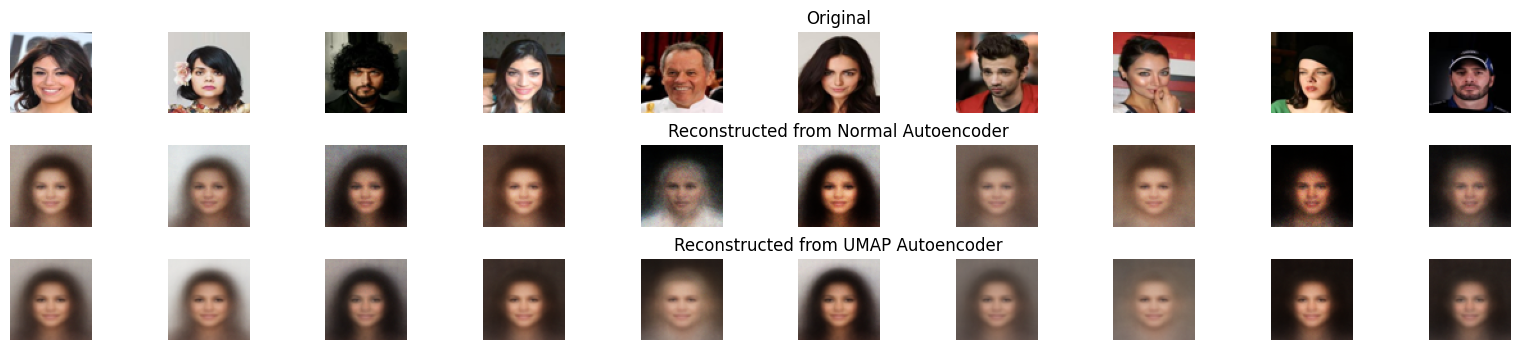

In [11]:
# Plot example image and reconstructions
normal_autoencoder.eval()
umap_autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(flat_test_loader))
    sample_images = sample_images.to(device).float()

    normal_autoencoder_reconstructed = normal_autoencoder(sample_images).cpu().numpy()
    umap_autoencoder_reconstructed = umap_autoencoder(sample_images).cpu().numpy()

    sample_images = sample_images.cpu().numpy()
    n = 10

    fig, ax = plt.subplots(3, n, figsize=(20, 4))
for i in range(n):
    # Original
    ax[0, i].imshow(sample_images[i].reshape(64, 64, 3))
    ax[0, i].axis("off")

    # Reconstructed from Normal autoencoder
    ax[1, i].imshow(normal_autoencoder_reconstructed[i].reshape(64, 64, 3))
    ax[1, i].axis("off")

    # Reconstructed from UMAP autoencoder
    ax[2, i].imshow(umap_autoencoder_reconstructed[i].reshape(64, 64, 3))
    ax[2, i].axis("off")

# Set titles
ax[0, 5].set_title("Original")
ax[1, 5].set_title("Reconstructed from Normal Autoencoder")
ax[2, 5].set_title("Reconstructed from UMAP Autoencoder")
plt.subplots_adjust(hspace=0.4)
plt.show()


### Plot UMAP Autoecoder results

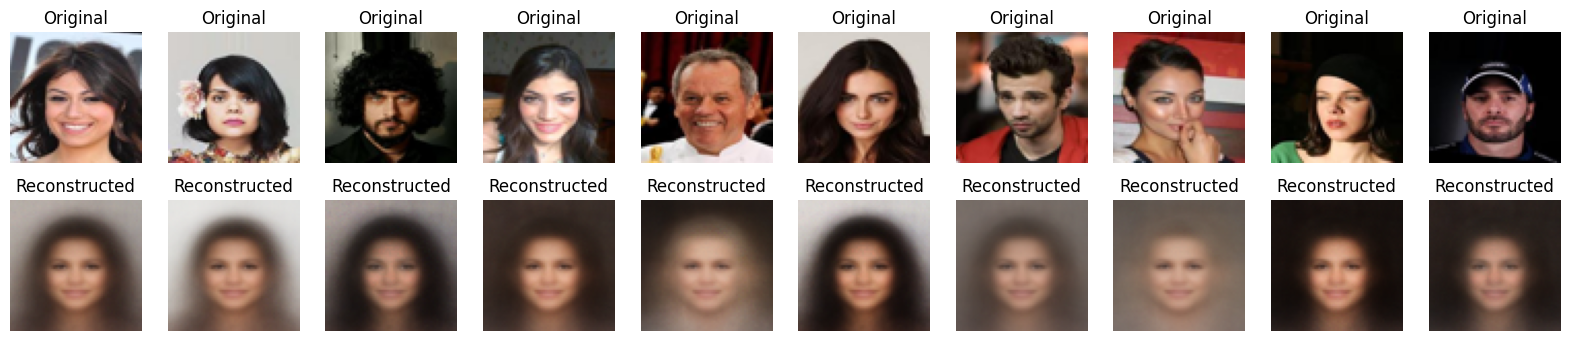

In [12]:
# Plot example image and reconstructions
umap_autoencoder.eval()
with torch.no_grad():
    sample_images, _ = next(iter(flat_test_loader))
    sample_images = sample_images.to(device).float()
    reconstructed = umap_autoencoder(sample_images).cpu().numpy()
    sample_images = sample_images.cpu().numpy()
    n = 10
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(sample_images[i].reshape(64, 64, 3), cmap="gray")
        plt.title("Original")
        plt.axis("off")

        # Reconstructed
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstructed[i].reshape(64, 64, 3), cmap="gray")
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

## Compare Metrics

In [13]:
# Test
normal_reconstruction_loss = test_autoencoder_reconstruction(
    normal_autoencoder, flat_test_loader, device
)
umap_reconstruction_loss = test_autoencoder_reconstruction(
    umap_autoencoder, flat_test_loader, device
)

print(f"Normal Autoencoder Reconstruction Loss: {normal_reconstruction_loss:.4f}")
print(f"UMAP Autoencoder Reconstruction Loss: {umap_reconstruction_loss:.4f}")

Normal Autoencoder Reconstruction Loss: 0.0373
UMAP Autoencoder Reconstruction Loss: 0.0446


In [14]:
normal_umap_embedding_loss = test_autoencoder_umap_embedding(
    normal_autoencoder, flat_test_loader, device
)
umap_umap_embedding_loss = test_autoencoder_umap_embedding(
    umap_autoencoder, flat_test_loader, device
)

print(f"Normal Autoencoder UMAP Embedding Loss: {normal_umap_embedding_loss:.4f}")
print(f"UMAP Autoencoder UMAP Embedding Loss: {umap_umap_embedding_loss:.4f}")

Normal Autoencoder UMAP Embedding Loss: 25.9300
UMAP Autoencoder UMAP Embedding Loss: 0.5196


# Recreate images from UMAP embedding

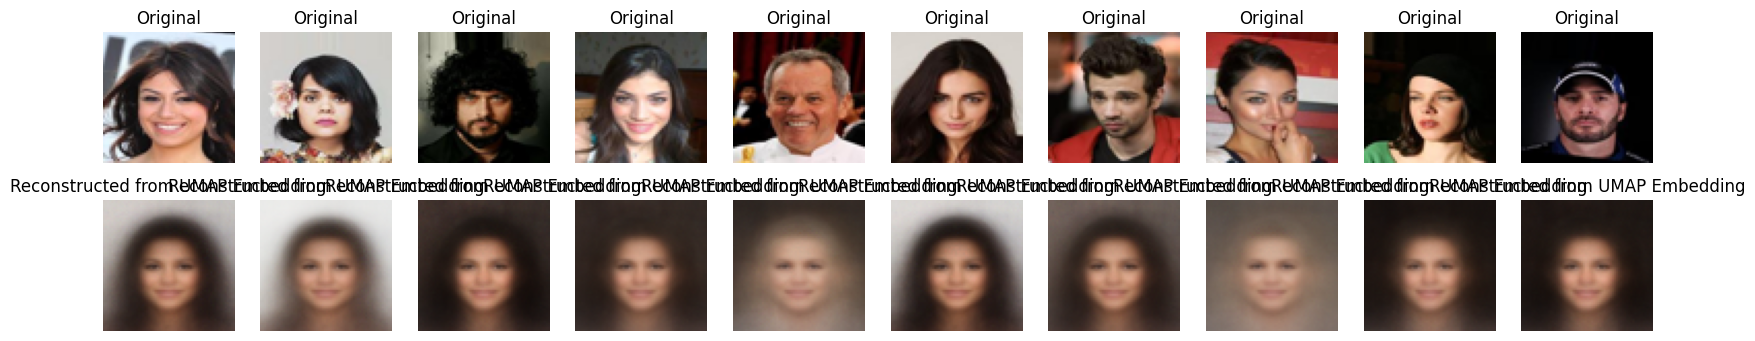

In [17]:
# pass all test UMAP embeddings through the UMAP decoder
reconstructed_test_images = (
    umap_autoencoder.decoder(
        torch.tensor(test_embeddings, dtype=torch.float32).to(device)
    )
    .cpu()
    .detach()
    .numpy()
)

# Plot some reconstructed images from UMAP embeddings
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # Original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(test_images[i].reshape(64, 64, 3))
    plt.title("Original")
    plt.axis("off")

    # Reconstructed from UMAP embedding
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructed_test_images[i].reshape(64, 64, 3))
    plt.title("Reconstructed from UMAP Embedding")
    plt.axis("off")
plt.show()

# Speed vs UMAP

In [18]:
# Test speed of real UMAP vs UMAP autoencoder's encoder (they do the same thing essentially)
import time

start_time = time.time()
test_embeddings = reducer.transform(flat_test_images)
umap_time = time.time() - start_time
print(f"UMAP transform time: {umap_time:.4f} seconds")

start_time = time.time()
test_embeddings_ae = umap_autoencoder.encoder(
    torch.tensor(flat_test_images, dtype=torch.float32).to(device)
)
umap_autoencoder_time = time.time() - start_time
print(f"UMAP Autoencoder encoder time: {umap_autoencoder_time:.4f} seconds")

UMAP transform time: 2.2385 seconds
UMAP Autoencoder encoder time: 0.1403 seconds
